In [1]:
# Import libraries
import pandas as pd
import sqlite3 as sql

from datetime import datetime, timedelta
from dateparser import parse
from timeit import default_timer as timer

In [2]:
# Import sales data from db
conn = sql.connect('domain_sales.db')
sales = pd.read_sql('SELECT * FROM SALES_MELB', conn)
sales.drop(columns=['index'], inplace=True)

In [3]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14429 entries, 0 to 14428
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        14429 non-null  object
 1   address     14429 non-null  object
 2   suburb      14429 non-null  object
 3   city        14429 non-null  object
 4   prop_type   14429 non-null  object
 5   beds        14420 non-null  object
 6   price       12418 non-null  object
 7   prop_url    14429 non-null  object
 8   agency      14429 non-null  object
 9   agency_url  13887 non-null  object
dtypes: object(10)
memory usage: 1.1+ MB


In [4]:
# Clean the data

# 1. Price
def price_clean(price):
    """ Clean up price; replace missing price with None and convert available price to float. """
    if price is None:
        return price
    elif price[0] == '$':
        if price[-1] == 'k':
            return round(float(price[1:-1])*1000, 2)
        elif price[-1] == 'm':
            return round(float(price[1:-1])*1000000, 2)
        else:
            return None
    elif price[0].isalpha():
        return None
    else:
        return float(price)
    
sales['price'] = sales['price'].apply(lambda x: price_clean(x))
sales.to_sql('SALES_MELB', conn, if_exists='replace')
conn.close()

In [5]:
sales.head()

,date,address,suburb,city,prop_type,beds,price,prop_url,agency,agency_url
0,2020-07-25,124 Park St,Abbotsford,Melbourne,House,2 beds,1142500.0,https://www.domain.com.au/124-park-street-abbo...,Biggin & Scott Richmond,http://www.domain.com.au/real-estate-agencies/...
1,2020-07-25,203R/88 Trenerry Cr,Abbotsford,Melbourne,Unit,1 bed,NaN,https://www.domain.com.au/203r-88-trenerry-cre...,McGrath Coburg / Brunswick,http://www.domain.com.au/real-estate-agencies/...
2,2020-07-25,9/11 Flockhart St,Abbotsford,Melbourne,Unit,2 beds,390000.0,https://www.domain.com.au/9-11-flockhart-stree...,Collings Real Estate,http://www.domain.com.au/real-estate-agencies/...
3,2020-07-25,8 Jean St,Aberfeldie,Melbourne,House,4 beds,1800000.0,https://www.domain.com.au/8-jean-street-aberfe...,Nelson Alexander Essendon,http://www.domain.com.au/real-estate-agencies/...
4,2020-07-25,3/9 West Ct,Airport West,Melbourne,Townhouse,2 beds,615000.0,https://www.domain.com.au/3-9-west-court-airpo...,Barry Plant Essendon,http://www.domain.com.au/real-estate-agencies/...


In [6]:
# 2. Date conversion
sales['date'] = pd.to_datetime(sales['date'])

In [7]:
# 3. Suburb
sales['suburb'].replace({'melbourne': 'Melbourne'}, inplace=True)
sales['suburb'].value_counts().sort_values()

Ryanston          1
Little River      1
Muckleford        1
Mount Beauty      1
Tatura East       1
               ... 
Preston         120
Coburg          120
Pakenham        142
Craigieburn     160
Reservoir       201
Name: suburb, Length: 875, dtype: int64

In [8]:
# 4. Property type
sales['prop_type'].replace({'Semi': 'Semi-detached', 'Terrace': 'Townhouse'}, inplace=True)
sales['prop_type'].value_counts()

House            10517
Unit              2464
Townhouse         1378
Villa               64
Studio               5
Semi-detached        1
Name: prop_type, dtype: int64

In [9]:
# 5. Nr Bedrooms
sales['beds'] = sales['beds'].apply(lambda x: int(x[0]) if x else None)
sales['beds'].replace({0: None}, inplace=True)
sales['beds'].sort_values()

13092       1
4813        1
2885        1
8781        1
13660       1
         ... 
11478    None
11599    None
12328    None
12912    None
13034    None
Name: beds, Length: 14429, dtype: object

In [10]:
# Engineer additional date features
sales['year'] = sales['date'].dt.year
sales['month'] = sales['date'].dt.month

In [11]:
# Import locality data
locality = pd.read_excel('vic_locality.xlsx', header=2)
locality.columns = locality.columns.str.replace('\r','').str.replace('\n','')
locality.drop(columns=['WardName', 'LGA', 'DistrictCode', 'RegionCode', 'ElectorCount'], inplace=True)
locality.rename({'Locality Name': 'suburb', 
                 'PostCode': 'postcode', 
                 'MunicipalityName': 'council', 
                 'DistrictName': 'district',
                 'RegionName': 'region',
                 'PropertyCount': 'prop_count'}, axis=1, inplace=True)

# Aggregate property count by suburb
prop_count_agg = locality.groupby('suburb')['prop_count'].sum().reset_index()

# Remove suburb duplicates by assigning ward with largest property count
locality = locality.groupby('suburb')['prop_count'].max().reset_index().merge(locality)

# Restore aggregate property count per suburb
locality = locality.merge(prop_count_agg, on='suburb', suffixes=('DROP', '')).drop(columns='prop_countDROP')

# Get distance to cbd
dist = pd.read_excel('melb_dist_cbd.xlsx').iloc[:,1:]
dist.rename(columns={'Suburb': 'suburb', 'Distance': 'distance_cbd', 'Median Price': 'median_price'}, inplace=True)
dist['distance_cbd'] = dist['distance_cbd'].apply(lambda x: float(x.split()[0][:-2]))
dist['median_price'] = dist['median_price'].apply(lambda x: round(float(x.replace('$', '').replace(',','')), 2) if type(x)==str else None)

# Add distance to cbd to locality data
locality = locality.merge(dist)

In [12]:
# Council to suburb mapping
df = sales.merge(locality).sort_values('suburb')

In [13]:
"""
page = 0
url = f'http://house.speakingsame.com/suburbtop.php?sta=vic&cat=Distance%20to%20CBD&name=&page={page}'
dist = pd.read_html(url)[5]
dist.columns = dist.iloc[0]
dist = dist.iloc[1:]

for page in range(1, 22):
    url = f'http://house.speakingsame.com/suburbtop.php?sta=vic&cat=Distance%20to%20CBD&name=&page={page}'
    dist_cont = pd.read_html(url)[5]
    dist_cont.columns = dist_cont.iloc[0]
    dist_cont = dist_cont.iloc[1:]
    dist = dist.append(dist_cont)
    
dist.set_index('Rank', drop=True, inplace=True)
dist.to_excel('melb_dist_cbd.xlsx')
"""

"\npage = 0\nurl = f'http://house.speakingsame.com/suburbtop.php?sta=vic&cat=Distance%20to%20CBD&name=&page={page}'\ndist = pd.read_html(url)[5]\ndist.columns = dist.iloc[0]\ndist = dist.iloc[1:]\n\nfor page in range(1, 22):\n    url = f'http://house.speakingsame.com/suburbtop.php?sta=vic&cat=Distance%20to%20CBD&name=&page={page}'\n    dist_cont = pd.read_html(url)[5]\n    dist_cont.columns = dist_cont.iloc[0]\n    dist_cont = dist_cont.iloc[1:]\n    dist = dist.append(dist_cont)\n    \ndist.set_index('Rank', drop=True, inplace=True)\ndist.to_excel('melb_dist_cbd.xlsx')\n"

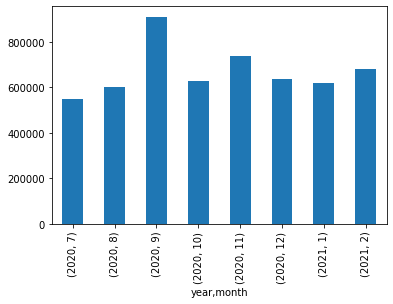

In [14]:
df[(df['council']=='Greater Geelong City Council')&(df['prop_type']=='House')&(df['beds']>=3)].groupby(['year', 'month'])['price'].median().plot.bar()

In [15]:
filtered = df[(df['council']=='Greater Geelong City Council')&(df['prop_type']=='House')&(df['beds']>=3)]

In [16]:
geelong_suburbs_monthly = filtered.groupby(['year', 'month', 'suburb'])['price'].median().reset_index()
geelong_suburbs_monthly['monthly_change_median'] = geelong_suburbs_monthly['price'].pct_change()
geelong_suburbs_monthly['prop_count'] = filtered.groupby(['year', 'month', 'suburb'])['address'].count().values
geelong_suburbs_monthly = geelong_suburbs_monthly.merge(filtered[['suburb', 'median_price']].drop_duplicates())
geelong_suburbs_monthly

,year,month,suburb,price,monthly_change_median,prop_count,median_price
0,2020,7,Bell Park,512500.0,NaN,2,499300.0
1,2020,10,Bell Park,565000.0,-0.548902,3,499300.0
2,2020,12,Bell Park,435000.0,-0.548638,1,499300.0
3,2021,2,Bell Park,560500.0,-0.542449,2,499300.0
4,2020,7,Bell Post Hill,483750.0,-0.056098,2,533200.0
...,...,...,...,...,...,...,...
170,2020,12,Drumcondra,980000.0,0.496183,1,1435800.0
171,2020,12,Fyansford,899000.0,-0.009912,1,841800.0
172,2021,1,North Shore,580000.0,-0.270440,1,567800.0
173,2021,2,North Shore,580000.0,-0.340909,1,567800.0


In [17]:
geelong_suburbs = geelong_suburbs_monthly.groupby(['suburb'])['monthly_change_median'].mean().reset_index()
geelong_suburbs.rename(columns={'monthly_change_median': 'monthly_change_avg'}, inplace=True)
geelong_suburbs['prop_count'] = filtered.groupby(['suburb'])['address'].count().values
geelong_suburbs = geelong_suburbs.merge(filtered[['suburb', 'median_price']].drop_duplicates())
geelong_suburbs.sort_values(by=['monthly_change_avg'], ascending=False)

,suburb,monthly_change_avg,prop_count,median_price
20,Lovely Banks,1.467633,1,815300.0
25,Newtown,1.117926,22,1008200.0
0,Barwon Heads,0.839502,8,1228200.0
21,Manifold Heights,0.670983,7,771000.0
29,Ocean Grove,0.601187,56,897400.0
6,Curlewis,0.505012,14,601100.0
7,Drumcondra,0.496183,1,1435800.0
11,Geelong,0.485832,5,887500.0
27,North Geelong,0.411240,8,573800.0
3,Belmont,0.358079,54,622600.0


In [18]:
geelong_suburbs.sort_values(by=['prop_count'], ascending=False)

,suburb,monthly_change_avg,prop_count,median_price
16,Highton,0.235283,58,746300.0
29,Ocean Grove,0.601187,56,897400.0
3,Belmont,0.358079,54,622600.0
4,Clifton Springs,-0.159747,35,569500.0
18,Lara,-0.147001,30,585000.0
5,Corio,-0.205556,29,394600.0
14,Hamlyn Heights,0.008143,24,593100.0
19,Leopold,-0.048847,23,565700.0
25,Newtown,1.117926,22,1008200.0
13,Grovedale,-0.248286,21,575000.0


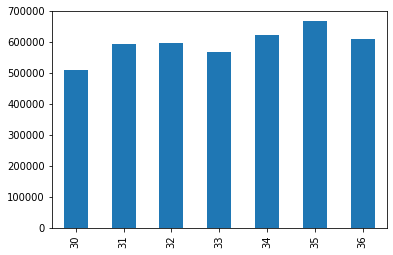

In [27]:
geelong_suburbs_monthly[geelong_suburbs_monthly['suburb']=='Grovedale']['price'].plot.bar()